In [1]:
!date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import hypergeom
from re import search
import csv

import sys
sys.path.append('../GOCAM_Project/dev')
import utils

Thu Dec  1 09:22:13 PST 2022


In [2]:
#import the reactome data
data_reactome = pd.read_csv("~/Downloads/metabolic_gocams2genes_20220728.tsv", header=0, names=["gocam", "title", "identifier","taxon","taxon_labels","modelstate"], sep="\t")
data_reactome['identifier'] = data_reactome['identifier'].apply(lambda x: x.split(','))
data_reactome['taxon_labels'] = data_reactome['taxon_labels'].apply(lambda x: x.split(','))
data_reactome['title']=data_reactome['title'].apply(lambda x: x.split('^')[0])
data_reactome['modelstate']=data_reactome['modelstate'].apply(lambda x: x.split('^')[0])
data_reactome['gocam']=data_reactome['gocam'].apply(lambda x: x[1:len(x)-1])
data_reactome = data_reactome[data_reactome['taxon_labels'].apply(lambda x: 'Homo sapiens' in x)]
data_reactome = data_reactome[['gocam','title','identifier']]
data_reactome

,gocam,title,identifier
0,http://model.geneontology.org/R-HSA-997272,Inhibition of voltage gated Ca2+ channels via ...,[http://purl.obolibrary.org/obo/go/extensions/...
1,http://model.geneontology.org/R-HSA-1296041,Activation of G protein gated Potassium channe...,[http://purl.obolibrary.org/obo/go/extensions/...
2,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - imported ...,[http://purl.obolibrary.org/obo/go/extensions/...
3,http://model.geneontology.org/R-HSA-2871809,FCERI mediated Ca+2 mobilization - imported fr...,[http://purl.obolibrary.org/obo/go/extensions/...
4,http://model.geneontology.org/R-HSA-2029485,Role of phospholipids in phagocytosis - import...,[http://purl.obolibrary.org/obo/go/extensions/...
...,...,...,...
1082,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - imported from:...,[http://purl.obolibrary.org/obo/go/extensions/...
1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,"[http://identifiers.org/uniprot/Q9Y2B2, http:/..."
1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),"[http://identifiers.org/uniprot/Q8N884, http:/..."
1095,http://model.geneontology.org/5a5fc23a00000008,adenylate cyclase test 20180123,"[http://identifiers.org/uniprot/Q08828, http:/..."


In [4]:
#import the production data
data = pd.read_csv("~/Downloads/gocams2genes_20220728.txt", header=0, names=["gocam", "title", "gp_labels","identifier","taxon","taxon_label","modelstate"], sep="\t")
data['gp_labels'] = data['gp_labels'].apply(lambda x: x.split(','))
data['identifier'] = data['identifier'].apply(lambda x: x.split(','))
data['title']=data['title'].apply(lambda x: x.split('^')[0])
data['modelstate']=data['modelstate'].apply(lambda x: x.split('^')[0])
data['gocam']=data['gocam'].apply(lambda x: x[1:len(x)-1])
data_human = data[data['taxon_label'].apply(lambda x: ('Mus musculus' not in x) and ('Homo sapiens' in x))]
mouse = data[data.taxon_label.apply(lambda x: ('Mus musculus' in x) and ('Homo sapiens' not in x))]
data_human = data_human[['gocam','title','identifier']]
data_both = data[data.taxon_label.apply(lambda x: ('Mus musculus' in x)and ('Homo sapiens' in x))]
len(data_both.identifier.values[0])

37

In [5]:
mouse = mouse.explode('identifier')
mouse.identifier.apply(lambda x: x.split('/')[-2]).value_counts()

mgi    482
obo      1
Name: identifier, dtype: int64

In [6]:
mouse_mgi = mouse[mouse.identifier.apply(lambda x: 'MGI:' in x)]
mouse_non_mgi = mouse[mouse.identifier.apply(lambda x: 'MGI:' not in x)]
mouse_mgi.identifier = mouse_mgi.identifier.apply(lambda x: x.split('/')[-1])

table = pd.read_csv('../data/simplemine_results.txt',sep='\t', header=3)
table['Mouse Ortholog'] = table['Mouse Ortholog'].apply(lambda x: x.split(' | '))
table = table.explode('Mouse Ortholog')
d= pd.Series(table['UniProtKB ID'].values,index=table['Mouse Ortholog'].apply(lambda x: x[:x.rfind(":")])).to_dict()
mouse_mgi['h_uniprot'] = mouse_mgi.identifier.apply(lambda x: d.get(x,'NO ORTHOLOG FOUND'))
mouse_mgi = mouse_mgi[mouse_mgi["h_uniprot"] != 'N.A.']
#just picking the first uniprot entry, because the canonical one isn't indicated in the simplemine results
mouse_mgi['identifier']=mouse_mgi['h_uniprot'].apply(lambda x: 'http://identifiers.org/uniprot/'+x.split(' | ')[0])
mouse_mgi = mouse_mgi[['gocam','title','identifier']]

/Users/nicholasmarkarian/opt/miniconda3/envs/gocam/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nicholasmarkarian/opt/miniconda3/envs/gocam/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [8]:
#There are 4 models in the reactome file that don't appear to be actually from reactome
data_reactome_cleaned = data_reactome[data_reactome['gocam'].apply(lambda x: '/R-' in x)]

The next two cells verify that all cases of uniprot IDs from the metabolic models tsv are from these 4 non-reactome gocams

In [9]:
data_reactome = data_reactome.explode('identifier')
data_reactome.reset_index(inplace=True)
data_reactome[data_reactome['gocam'].apply(lambda x: 'R-' not in x)]

,index,gocam,title,identifier
5315,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9Y2B2
5316,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q7Z7B1
5317,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/P37287
5318,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9H3S5
5319,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/O60762
5320,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q8N884
5321,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q86WV6
5322,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q92993-4
5323,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q9NSU2-3
5324,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q96GD4-1


In [10]:
data_reactome[data_reactome['identifier'].apply(lambda x: 'uniprot' in x)]

,index,gocam,title,identifier
5315,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9Y2B2
5316,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q7Z7B1
5317,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/P37287
5318,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9H3S5
5319,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/O60762
5320,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q8N884
5321,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q86WV6
5322,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q92993-4
5323,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q9NSU2-3
5324,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q96GD4-1


In [12]:
uIDs = utils.csv2dict('../data/uIDs.csv')

In [13]:
#needed to update identifiers.csv after importing the new reactome models... dependence of the reactome2uniprot notebook on this line is bad
#data2matrix(data_reactome_cleaned).identifier.to_csv('../data/identifiers.csv')

In [14]:
#expand rows
data_reactome = data_reactome_cleaned.explode('identifier')
data_reactome.reset_index(inplace=True)
data_ = pd.concat([data_human.explode('identifier'),mouse_mgi])
data_.reset_index(inplace=True)

#data_reactome = data2matrix(data_reactome_cleaned)
#data_ = data2matrix(data)

#KEEP ONLY UNIPROT, GO COMPLEX
data_uniprot = data_[data_.identifier.apply(lambda x: 'uniprot' in x) ]
data_uniprot.identifier = data_uniprot.identifier.apply(lambda x: x.split('/')[-1])
data_GOcomplex = data_[data_.identifier.apply(lambda x: 'obo/GO_' in x) ]

#map IDs using uIDs dictionary
data_reactome['uniprot']=data_reactome['identifier'].apply(lambda x: uIDs.get(x,'NOT FOUND'))
num_before = len(data_reactome)
not_mapped = data_reactome[data_reactome['uniprot'] == 'NOT FOUND']
data_reactome = data_reactome[data_reactome['uniprot'] != 'NOT FOUND'] 
num_lost = num_before - len(data_reactome)
data_reactome['identifier'] = data_reactome['uniprot']
data_reactome = data_reactome.drop('uniprot',axis=1)
num_lost

/Users/nicholasmarkarian/opt/miniconda3/envs/gocam/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


129

In [15]:
not_mapped.identifier.apply(lambda x: x.split('REACTO_')[-1]).unique()

array(['R-HSA-451336', 'R-HSA-2565924', 'R-HSA-8939790', 'R-HSA-8939797',
       'R-HSA-2453687', 'R-HSA-2470277', 'R-HSA-5693080', 'R-HSA-175986',
       'R-HSA-453132', 'R-HSA-5635063', 'R-HSA-8960083', 'R-CPE-9661715',
       'R-CPE-9661737', 'R-HSA-9661701', 'R-HSA-9663470', 'R-HSA-2545205',
       'R-HSA-974998', 'R-HSA-9604605', 'R-HSA-351835', 'R-HSA-5244779',
       'R-HSA-2161915', 'R-HSA-9026899', 'R-HSA-9027561', 'R-HSA-9028288',
       'R-HSA-9022670', 'R-HSA-2161751', 'R-HSA-9024779', 'R-HSA-9025025',
       'R-HSA-8957350', 'R-HSA-9029001', 'R-HSA-428470', 'R-HSA-9027665',
       'R-HSA-5250898', 'R-HSA-8853807', 'R-HSA-74731', 'R-HSA-74819',
       'R-HSA-69593', 'R-HSA-8867341', 'R-HSA-8876883', 'R-ALL-72617',
       'R-HSA-2869445', 'R-HSA-170641', 'R-HSA-71237', 'R-HSA-165022',
       'R-HSA-70827', 'R-HSA-3076903', 'R-HSA-2167826', 'R-HSA-2167848',
       'R-HSA-8953316', 'R-HSA-8953409', 'R-HSA-8953410', 'R-HSA-5661266',
       'R-HSA-5490258', 'R-HSA-5359039', 'R-H

In [16]:
data_reactome = data_reactome.explode('identifier')
data_reactome.reset_index(inplace=True)
data_reactome.title = data_reactome.title.apply(lambda x : x.replace("imported from: Reactome","Reactome"))
#data_reactome = data2matrix(data_reactome)

In [17]:
data_final = pd.concat([data_uniprot,data_reactome])
data_final = data_final[['gocam','title','identifier']]
data_final = data_final.drop_duplicates()
#data_final.identifier = data_final.identifier.apply(lambda x: x.split('/')[-1])


In [18]:
data_final[data_final.identifier.apply(lambda x: 'sset' in x)]

,gocam,title,identifier
0,http://model.geneontology.org/R-HSA-997272,Inhibition of voltage gated Ca2+ channels via ...,sset:Kir heterotetramers
3,http://model.geneontology.org/R-HSA-1296041,Activation of G protein gated Potassium channe...,sset:Kir heterotetramers
6,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,"sset:p-PLC gamma1,2"
9,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,sset:PLC-beta
10,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,sset:G-protein alpha (q/11/14/15)
...,...,...,...
11309,http://model.geneontology.org/R-HSA-1227986,Signaling by ERBB2 - Reactome,sset:ERBB2 heterodimers
11311,http://model.geneontology.org/R-HSA-1227986,Signaling by ERBB2 - Reactome,sset:p-Y877-ERBB2 heterodimers
11313,http://model.geneontology.org/R-HSA-1227986,Signaling by ERBB2 - Reactome,sset:p-Y419/420/426-N-myristoyl-SRC/FYN/YES1
11361,http://model.geneontology.org/R-HSA-1253288,Downregulation of ERBB4 signaling - Reactome,sset:WWP1/ITCH


In [19]:
setID2members = utils.csv2dict('../data/setID2members.csv')
bad_sets = []
def check_set(setID):
    if (setID in setID2members) and (len(setID2members.get(setID))==0):
        bad_sets.append(setID)
        return 'BAD_SET_'+setID
    else:
        return setID


In [20]:
t = data_final.copy()
t.identifier = t.identifier.apply(lambda x: check_set(x))
t[t.identifier.apply(lambda x: 'BAD_SET' in x)]

,gocam,title,identifier
398,http://model.geneontology.org/R-HSA-180024,DARPP-32 events - Reactome,BAD_SET_sset:DARPP-32 phosphorylated on T34
405,http://model.geneontology.org/R-HSA-180024,DARPP-32 events - Reactome,BAD_SET_sset:p-T75-DARPP32s
876,http://model.geneontology.org/R-HSA-1614635,Sulfur amino acid metabolism - Reactome,BAD_SET_sset:MAT1A multimers
888,http://model.geneontology.org/R-HSA-156581,Methylation - Reactome,BAD_SET_sset:MAT1A multimers
1002,http://model.geneontology.org/R-HSA-5628897,TP53 Regulates Metabolic Genes - Reactome,BAD_SET_sset:G6PD dimer and tetramer
1192,http://model.geneontology.org/R-HSA-499943,Interconversion of nucleotide di- and triphosp...,BAD_SET_sset:G6PD dimer and tetramer
1206,http://model.geneontology.org/R-HSA-3299685,Detoxification of Reactive Oxygen Species - Re...,BAD_SET_sset:G6PD dimer and tetramer
1224,http://model.geneontology.org/R-HSA-3299685,Detoxification of Reactive Oxygen Species - Re...,BAD_SET_sset:SOD3 (cleaved and uncleaved)
2017,http://model.geneontology.org/R-HSA-71336,Pentose phosphate pathway - Reactome,BAD_SET_sset:G6PD dimer and tetramer
2398,http://model.geneontology.org/R-HSA-9013973,TICAM1-dependent activation of IRF3/IRF7 - Rea...,BAD_SET_sset:TLR3 ligand


In [21]:
len(data_final)

11306

In [22]:
data_final = t[t.identifier.apply(lambda x: 'BAD_SET' not in x)]
data_final

,gocam,title,identifier
0,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P29597
1,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),Q14765
2,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P29459
3,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P29460
4,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P42701
...,...,...,...
11394,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,O60673
11395,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,Q9UI95
11396,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,Q9NS91
11397,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,P63146


In [23]:
data_final.to_csv('../data/data_final_mouse.csv')
modelID2title = pd.Series(data_final.title.values,index=data_final.gocam)
modelID2title.to_csv('../data/modelID2title_mouse.csv')
data_final[data_final.identifier.apply(lambda x: ('/' in x))]


,gocam,title,identifier
10,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,sset:G-protein alpha (q/11/14/15)
17,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,sset:PLC-beta 1/2/3
37,http://model.geneontology.org/R-HSA-2871809,FCERI mediated Ca+2 mobilization - Reactome,sset:G-protein alpha (q/11/14/15)
44,http://model.geneontology.org/R-HSA-2871809,FCERI mediated Ca+2 mobilization - Reactome,sset:PLC-beta 1/2/3
58,http://model.geneontology.org/R-HSA-2871809,FCERI mediated Ca+2 mobilization - Reactome,sset:SYK/BTK
...,...,...,...
11220,http://model.geneontology.org/R-HSA-1250347,SHC1 events in ERBB4 signaling - Reactome,sset:NRGs/EGF-like ligands
11250,http://model.geneontology.org/R-HSA-1236394,Signaling by ERBB4 - Reactome,sset:NRGs/EGF-like ligands
11313,http://model.geneontology.org/R-HSA-1227986,Signaling by ERBB2 - Reactome,sset:p-Y419/420/426-N-myristoyl-SRC/FYN/YES1
11361,http://model.geneontology.org/R-HSA-1253288,Downregulation of ERBB4 signaling - Reactome,sset:WWP1/ITCH


In [24]:
data_final[data_final.identifier.apply(lambda x: 'sset:' in x)]

,gocam,title,identifier
0,http://model.geneontology.org/R-HSA-997272,Inhibition of voltage gated Ca2+ channels via ...,sset:Kir heterotetramers
3,http://model.geneontology.org/R-HSA-1296041,Activation of G protein gated Potassium channe...,sset:Kir heterotetramers
6,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,"sset:p-PLC gamma1,2"
9,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,sset:PLC-beta
10,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - Reactome,sset:G-protein alpha (q/11/14/15)
...,...,...,...
11309,http://model.geneontology.org/R-HSA-1227986,Signaling by ERBB2 - Reactome,sset:ERBB2 heterodimers
11311,http://model.geneontology.org/R-HSA-1227986,Signaling by ERBB2 - Reactome,sset:p-Y877-ERBB2 heterodimers
11313,http://model.geneontology.org/R-HSA-1227986,Signaling by ERBB2 - Reactome,sset:p-Y419/420/426-N-myristoyl-SRC/FYN/YES1
11361,http://model.geneontology.org/R-HSA-1253288,Downregulation of ERBB4 signaling - Reactome,sset:WWP1/ITCH


In [25]:
len(data_final[data_final.title.apply(lambda x: ('mouse' in x) or ('Mouse' in x))].title.unique())

76

([<matplotlib.axis.XTick at 0x7f7bfba2e510>,
 <a list of 15 Text major ticklabel objects>)

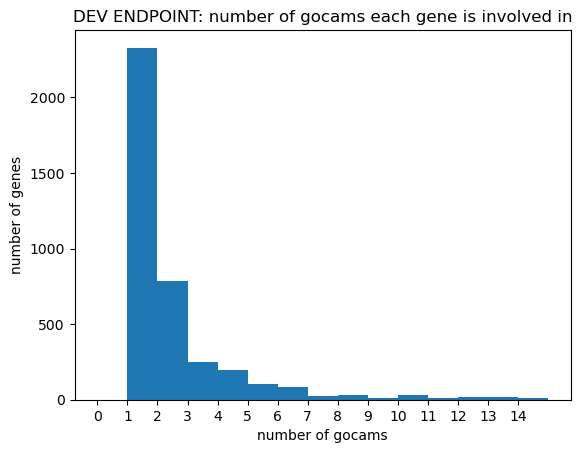

In [26]:
D = {}
D = utils.update_dict(D, data_final[['gocam','identifier']],'identifier','gocam')
x = []
for key in D:
    num_gocams = len(D.get(key))
    x.append(num_gocams)
plt.hist(x, bins=15, range=(0,15))
plt.xlabel("number of gocams")
plt.ylabel("number of genes")
plt.title("DEV ENDPOINT: number of gocams each gene is involved in")
plt.xticks(np.arange(0,15))

In [ ]:
def get_sizes (data): #data= dataframe with gocam IDs and gene identifiers as columns
    return data['gocam'].value_counts()
    

In [34]:
gocam_sizes = get_sizes(data_final)
gocam_sizes.to_csv('../data/gocam_sizes_mouse.csv',header=['sizes'],index_label='gocam')
Dict = {}
Dict = utils.update_dict(Dict, data_final, 'identifier','gocam')
utils.dict2csv(Dict,'../data/ID2gocam_mouse.csv')

In [36]:
Dict_r = {}
Dict_r = utils.update_dict(Dict_r, data_final, 'gocam','identifier')
utils.dict2csv(Dict_r,'../data/gocam2ID_mouse.csv')

genes = pd.DataFrame( {'g':mouse_mgi.identifier})
species = 'mouse'
genes.g = genes.g.str.upper()
input_type = 'Gene ID' #MGI

no_ortho = []
if species == 'mouse':
    file = '../data/simplemine_results_mouse.txt'
    table = pd.read_csv(file,sep='\t', header=3)
    d= pd.Series(table['Human Ortholog'].values,index=table[input_type]).to_dict()
    genes['mouse']=genes['g']
    genes['g']=genes['g'].apply(lambda x: d.get(x,'NO ORTHOLOG FOUND')) #human orthologs as HGNC
    no_ortho = genes[genes.g == 'NO ORTHOLOG FOUND']
    genes = genes[genes.g != 'NO ORTHOLOG FOUND']
    input_type = 'Gene ID' #new input type for the subsequent human HGNC->uniprot mapping
    
    